#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 18

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.73254634,  0.68068863,  0.00623273],
       [ 0.01099601, -0.02098767,  0.99971926],
       [ 0.68062834, -0.73227216, -0.0228593 ]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001211


In [33]:
Ret.shape

(18, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000210


In [37]:
C1(dx,dy,dz,Ret)

array([[ 1.31968632e+00,  1.15089439e-01,  1.17792318e+00,
         2.32405050e-01, -1.09278811e-01,  1.45230141e-01,
        -6.01718704e-03,  4.85747135e-01, -4.68183749e-01,
         7.64226731e-01,  4.30570606e-01, -5.38965454e-02,
         1.70923981e+00, -3.63513138e+00,  6.10867425e-04,
        -3.26909592e+00,  2.75436007e-01, -1.83349530e-03],
       [-8.68869951e-01, -1.65907539e-01, -2.82992924e+00,
         4.05290832e+00, -7.16065571e+00, -4.91143466e-02,
        -1.15437686e-02,  1.24688102e+00, -5.42612082e+00,
         1.54510444e+00, -5.91431376e-02, -8.97116974e-01,
        -1.24737994e+00,  4.08654373e-01,  1.88402833e-01,
        -1.43148866e-01,  3.95998434e-01,  4.47596067e-01],
       [ 7.19919423e-01,  5.86345262e-02, -5.90641964e-01,
         7.79751270e+00,  3.02810675e+00,  4.98713267e-02,
        -2.30082322e-02,  3.06727239e+00,  8.76429599e+00,
        -1.41889041e+00,  4.57186343e-01,  9.63631446e-01,
        -2.67832598e-01, -2.53501598e-02, -9.63912025e

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 7.57372457e+03, -4.98647414e+03,  4.13164200e+03],
       [ 6.60502197e+02, -9.52148995e+02,  3.36505536e+02],
       [ 6.76014110e+03, -1.62410600e+04, -3.38971428e+03],
       [ 1.33378047e+03,  2.32597784e+04,  4.47501900e+04],
       [-6.27154802e+02, -4.10952461e+04,  1.73784074e+04],
       [ 8.33480710e+02, -2.81868902e+02,  2.86213236e+02],
       [-3.45328406e+01, -6.62500799e+01, -1.32045025e+02],
       [ 2.78771929e+03,  7.15589251e+03,  1.76031803e+04],
       [-2.68692243e+03, -3.11406915e+04,  5.02985921e+04],
       [ 4.38592314e+03,  8.86740682e+03, -8.14306021e+03],
       [ 2.47105932e+03, -3.39424474e+02,  2.62380794e+03],
       [-3.09314103e+02, -5.14858476e+03,  5.53031357e+03],
       [ 9.80938526e+03, -7.15875580e+03, -1.53710037e+03],
       [-2.08621424e+04,  2.34528132e+03, -1.45485427e+02],
       [ 3.50578888e+00,  1.08125025e+03, -5.53192383e+04],
       [-1.87614524e+04, -8.21536202e+02, -1.01031343e+01],
       [ 1.58073659e+03,  2.27264845e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000248


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000288


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000025


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 1.81505119, -0.48817718, -0.53934314],
       [ 0.61048908, -0.28550701,  0.69056164],
       [-1.50080624,  0.08894156, -0.06847142],
       [ 0.41229845,  1.04906379, -0.47030059],
       [-1.18517942, -0.4523468 ,  0.11548153],
       [ 0.79971579, -1.03295597, -0.69453537],
       [-1.18741996,  0.85089801,  0.2457739 ],
       [ 0.19250572, -0.01544072, -0.59257602],
       [-1.88545277,  1.34756865, -0.21791251],
       [ 0.02826634,  0.26361052,  0.03272246],
       [-0.03469962,  0.81699805,  0.16627034],
       [ 0.9114848 ,  0.7644946 , -0.55142851],
       [ 0.19299546, -1.49685445, -0.3269172 ],
       [ 0.69676113,  0.59785781, -0.41396265],
       [-0.444535  ,  1.96360585, -0.91554828],
       [ 1.31419479, -1.12364146, -0.13932725],
       [ 0.45030385,  0.38756959,  0.2972522 ],
       [ 1.46168267, -1.25679124, -0.28276157]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000071


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000564


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000523


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 1.04043398,  0.15343635,  0.01852045],
       [-1.54134421, -0.74865605, -0.40840482],
       [-0.31087564, -1.82291799,  0.36075188],
       [ 1.47790382,  3.43180495, -1.38548674],
       [ 1.26810424,  0.68442554, -1.30823859],
       [ 0.17809228,  2.56591907, -0.51622353],
       [-0.50080123,  0.92755561,  0.65810901],
       [-0.15631787,  1.77285359, -0.06712774],
       [-1.84685868, -2.07602106, -1.31025074],
       [ 0.47651353, -0.48634762,  0.4244991 ],
       [-1.06609361,  1.89158959,  0.2758675 ],
       [-1.42275218,  0.28080093,  0.52226504],
       [-0.31792777,  0.4891629 ,  0.42402321],
       [-1.07788578, -1.08395812, -0.57390763],
       [-0.18691705, -1.12620284,  0.57865167],
       [ 1.79878497, -0.41249729, -0.43805655],
       [ 0.07726893,  0.47306842,  0.12820421],
       [-0.15237039, -1.2281987 ,  0.26906339]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-0.00048602,  0.00877137, -0.00141234, -0.01362215,  0.00508783,
         0.00299253, -0.00540279, -0.00519598, -0.01402172, -0.00206464,
        -0.00581506, -0.01180567,  0.01045339, -0.00907692, -0.02581487,
         0.00880192, -0.00079281,  0.0087024 ],
       [ 0.07022919, -0.06365781, -0.00657794,  0.05076439, -0.0221659 ,
         0.07667627, -0.0352275 ,  0.06103644,  0.00493787, -0.00302237,
        -0.01695329,  0.06335235,  0.03444984,  0.04767109,  0.08766295,
         0.02570736, -0.02572329,  0.0413843 ],
       [-0.06520233, -0.0340731 ,  0.02241232,  0.10129414, -0.03460884,
        -0.11059198,  0.09585897, -0.0032784 ,  0.15185642,  0.02613152,
         0.08208937,  0.06831682, -0.15156418,  0.05357027,  0.2005477 ,
        -0.12430027,  0.0347401 , -0.13895547]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000899


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.13290084e-07, -2.62670246e-07, -1.42134046e-06,
         1.90190806e-06, -5.51925655e-07, -1.84161469e-07,
        -3.86972689e-07, -2.24373328e-08,  2.91898204e-06,
        -5.03888383e-08, -1.03188987e-06, -1.49208880e-06,
         2.08443117e-06,  1.23737295e-06, -3.65157506e-07,
        -8.74629323e-07, -5.35223584e-07,  3.25028999e-06],
       [-5.68840586e-03, -2.82817189e-03,  1.15682168e-02,
        -9.08034828e-03, -5.80199434e-03,  5.52279095e-03,
        -9.87153044e-03,  5.12625387e-04, -1.85302978e-02,
        -1.62693793e-03,  6.67472581e-03,  1.22733156e-02,
        -7.05995327e-03, -5.48862316e-03, -6.74888899e-03,
         2.74314032e-03,  1.35863758e-03, -1.24412220e-02],
       [ 6.83309620e-03,  5.48168402e-03,  2.78889653e-03,
        -1.01313544e-02,  1.13775765e-02, -3.66276001e-03,
         1.37810431e-02, -2.86000193e-04, -1.09549194e-02,
         2.13602424e-03,  3.74859240e-03,  2.79842769e-03,
        -1.39956126e-02, -7.01044660e-03,  1.04378769e

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-7.57372457e+03, -6.60502197e+02, -6.76014110e+03,
        -1.33378047e+03,  6.27154802e+02, -8.33480710e+02,
         3.45328406e+01, -2.78771929e+03,  2.68692243e+03,
        -4.38592314e+03, -2.47105932e+03,  3.09314103e+02,
        -9.80938526e+03,  2.08621424e+04, -3.50578888e+00,
         1.87614524e+04, -1.58073659e+03,  1.05224918e+01],
       [ 4.98647414e+03,  9.52148995e+02,  1.62410600e+04,
        -2.32597784e+04,  4.10952461e+04,  2.81868902e+02,
         6.62500799e+01, -7.15589251e+03,  3.11406915e+04,
        -8.86740682e+03,  3.39424474e+02,  5.14858476e+03,
         7.15875580e+03, -2.34528132e+03, -1.08125025e+03,
         8.21536202e+02, -2.27264845e+03, -2.56876902e+03],
       [-4.25980654e+03, -4.64670078e+02,  3.26154973e+03,
        -4.48783546e+04, -1.75065719e+04, -4.14377779e+02,
         3.88048314e+00, -1.77313449e+04, -5.04267567e+04,
         8.01489566e+03, -2.75197248e+03, -5.65847812e+03,
         1.40893583e+03,  1.73208852e+01,  5.51910737e

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000742


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.05733892e+01, -4.14958705e+05,  6.22802242e+05],
       [-3.45775635e-01,  3.18237856e+03,  3.10319755e+02],
       [ 1.79526985e+02,  1.61850171e+05, -1.97535385e+06],
       [-1.31220749e+02,  3.31720526e+06, -1.99184430e+06],
       [ 2.43697928e+02, -3.61785419e+06,  1.15631797e+06],
       [ 7.04060803e+02, -3.44017835e+06, -3.67173180e+06],
       [ 8.65527073e+01, -1.12255386e+06,  2.48296821e+05],
       [-1.07335332e+02, -3.37752362e+05,  1.42201951e+06],
       [-5.69566469e+01,  6.52402651e+05, -7.70869887e+04],
       [-1.24297441e+02,  2.83986158e+06, -1.58441237e+06],
       [-1.46415033e+02, -3.39865597e+05,  1.81889725e+06],
       [ 1.85947652e+02, -1.76424423e+06, -1.14020341e+05],
       [ 5.16044523e+02, -3.15360457e+06, -2.05906984e+06],
       [-1.78145331e+02,  1.66332186e+06,  1.36132522e+05],
       [ 6.39399299e+01,  2.37621047e+06, -3.02222138e+06],
       [-3.66723432e+01,  2.93135295e+05,  7.72962687e+04],
       [ 5.02786873e+02, -3.59553518e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-8.43965551e+08,  6.21966716e+07,  4.14123222e+07],
       [-3.93101537e+08, -7.88508321e+03, -3.57152943e+05],
       [ 1.44616849e+07, -1.97533954e+08, -1.61835854e+07],
       [-2.02983252e+07, -1.99186440e+08, -3.31722535e+08],
       [ 1.05573052e+07,  1.15632842e+08,  3.61786465e+08],
       [ 3.70666728e+08, -3.67136484e+08,  3.44054529e+08],
       [-2.14791605e+08,  2.48084177e+07,  1.12234123e+08],
       [ 7.85470121e+06,  1.42202729e+08,  3.37760137e+07],
       [ 1.51686125e+08, -7.69368194e+06, -6.52252490e+07],
       [-6.23252637e+08, -1.58502939e+08, -2.84047856e+08],
       [ 3.75659150e+06,  1.81890097e+08,  3.39869316e+07],
       [-2.99743247e+07, -1.14050016e+07,  1.76421456e+08],
       [-6.02696070e+08, -2.05966650e+08,  3.15300793e+08],
       [-4.73180273e+07,  1.36085677e+07, -1.66336870e+08],
       [-4.93525868e+07, -3.02227024e+08, -2.37625932e+08],
       [-7.38742545e+08,  7.65649135e+06, -2.93866613e+07],
       [-6.82101456e+08, -1.48386968e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000286


In [76]:
Re_b(Ret).shape

(18, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000480


In [82]:
d_me_

array([[ 5.27826974e-03,  6.19063020e+02, -6.72412940e+02],
       [ 8.04282219e-06,  5.30713777e+02, -5.30821916e+02],
       [-7.50782938e-02,  4.16348071e+01,  7.16767990e+02],
       [ 2.87444774e-02, -4.81190845e+02,  1.90852309e+02],
       [ 4.04356366e-02, -5.16399161e+02,  1.07963927e+02],
       [ 1.57489771e-03, -2.26426889e+02,  2.10529502e+02],
       [-3.11821570e-02,  2.17431052e+02,  9.75451208e+01],
       [-9.17709096e-02,  4.63818507e+00,  9.22387284e+02],
       [ 8.44571772e-03,  1.81780947e+02, -2.67104747e+02],
       [-5.01122157e-04,  1.01630506e+02, -9.65735610e+01],
       [-1.23645305e-02, -5.35826282e+01,  1.78485899e+02],
       [ 3.01976985e-02, -2.24025053e+02, -8.10062581e+01],
       [-1.59579566e-03, -4.76244485e+00,  2.08826485e+01],
       [ 1.63789648e-02, -6.85065604e+01, -9.69424125e+01],
       [-3.46708840e-02, -1.66974833e+02,  5.17211932e+02],
       [ 2.03321678e-03,  7.38323768e+02, -7.58899763e+02],
       [-1.82935955e-02, -1.60590846e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-7.57372457e+03, -6.60502197e+02, -6.76014110e+03,
        -1.33378047e+03,  6.27154802e+02, -8.33480710e+02,
         3.45328406e+01, -2.78771929e+03,  2.68692243e+03,
        -4.38592314e+03, -2.47105932e+03,  3.09314103e+02,
        -9.80938526e+03,  2.08621424e+04, -3.50578888e+00,
         1.87614524e+04, -1.58073659e+03,  1.05224918e+01],
       [ 4.98647414e+03,  9.52148995e+02,  1.62410600e+04,
        -2.32597784e+04,  4.10952461e+04,  2.81868902e+02,
         6.62500799e+01, -7.15589251e+03,  3.11406915e+04,
        -8.86740682e+03,  3.39424474e+02,  5.14858476e+03,
         7.15875580e+03, -2.34528132e+03, -1.08125025e+03,
         8.21536202e+02, -2.27264845e+03, -2.56876902e+03],
       [-4.25980654e+03, -4.64670078e+02,  3.26154973e+03,
        -4.48783546e+04, -1.75065719e+04, -4.14377779e+02,
         3.88048314e+00, -1.77313449e+04, -5.04267567e+04,
         8.01489566e+03, -2.75197248e+03, -5.65847812e+03,
         1.40893583e+03,  1.73208852e+01,  5.51910737e

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3166645.82893617, 3165704.06893617, 3164762.30893617,
       3163820.54893617, 3162878.78893617, 3161937.02893617,
       3160995.26893617, 3160053.50893617, 3159111.74893617,
       3158169.98893617, 3157228.22893617, 3156286.46893617,
       3155344.70893617, 3154402.94893617, 3153461.18893617,
       3152519.42893617, 3151577.66893617, 3150635.90893617])

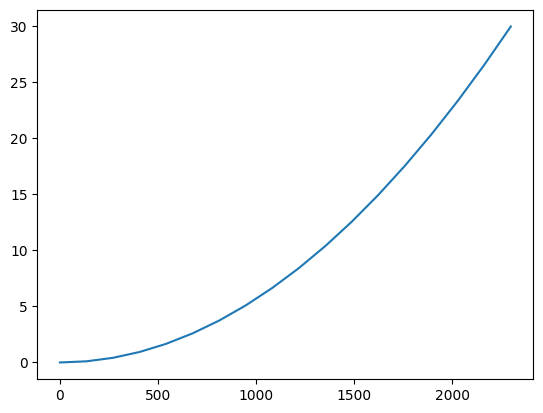

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 1.35196802e+02, 2.70393604e+02, 4.05590405e+02,
       5.40787207e+02, 6.75984009e+02, 8.11180811e+02, 9.46377613e+02,
       1.08157441e+03, 1.21677122e+03, 1.35196802e+03, 1.48716482e+03,
       1.62236162e+03, 1.75755842e+03, 1.89275523e+03, 2.02795203e+03,
       2.16314883e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_56565/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 1.35196802e+02, 2.70393604e+02, 4.05590405e+02,
       5.40787207e+02, 6.75984009e+02, 8.11180811e+02, 9.46377613e+02,
       1.08157441e+03, 1.21677122e+03, 1.35196802e+03, 1.48716482e+03,
       1.62236162e+03, 1.75755842e+03, 1.89275523e+03, 2.02795203e+03,
       2.16314883e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 1.35196802e+02, 2.70393604e+02, 4.05590405e+02,
       5.40787207e+02, 6.75984009e+02, 8.11180811e+02, 9.46377613e+02,
       1.08157441e+03, 1.21677122e+03, 1.35196802e+03, 1.48716482e+03,
       1.62236162e+03, 1.75755842e+03, 1.89275523e+03, 2.02795203e+03,
       2.16314883e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

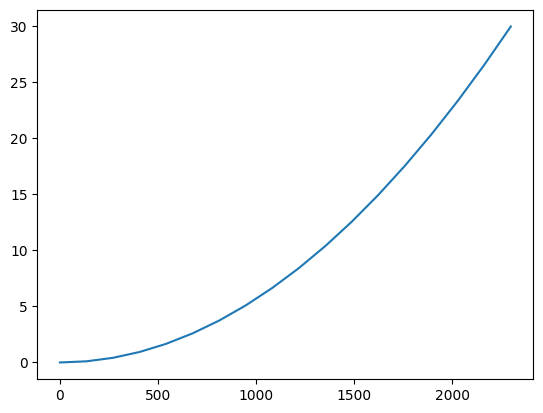

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
    
    glob_force = np.dot(K,np.array(vessel_movement))
    
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6) 
    
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]
#     print(F,'F')
#     print(F)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T.astype(np.float64)
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        vessel_movement=[-0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0],
        coefs=[1,1,1,1,1,1])

In [113]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [114]:
f

array([-9.99786375e+03, -3.59333333e+00,  2.00042617e+04,  5.25000000e-02,
        1.75000000e-02,  3.18500000e-01,  9.87000000e+03, -3.06133333e+01,
       -1.07846667e+02, -2.03000000e+00, -1.74020000e+02,  2.99600000e+01,
        9.03000000e+01, -3.92933333e+01, -1.98520000e+04,  3.86400000e+01,
        1.23200000e+02, -1.59600000e+00,  3.75637500e+01,  7.35000000e+01,
       -4.44150000e+01, -9.64425000e+01, -1.83750000e+00, -8.70975000e+01])

In [115]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    
    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement
#     print (vessel_move)
    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)
#     print('d',d)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02, 
 0.03, 
 0.01, 
 -0.05, 
 0.03],
 [1,1,1,1,1,1]
)

In [117]:
fors

array([[-1.35144755e+06,  1.01908276e+04, -1.70726645e+04],
       [-5.34765422e-06,  8.08674376e-05,  8.57736450e-06],
       [ 1.20762736e-04,  7.35861249e-06,  2.97009246e-05],
       [-1.67351216e-04,  1.06529635e-05,  3.62348510e-06],
       [ 1.53899193e-04, -2.23964453e-05, -1.56993046e-05],
       [ 3.52859497e-05,  7.45058060e-06, -4.33884561e-05],
       [-5.67436218e-05, -3.30582261e-05, -5.84125519e-06],
       [ 1.52587891e-05,  1.31836538e-04, -3.45744193e-05],
       [ 2.14576721e-05,  6.67124987e-05, -3.28794122e-05],
       [-1.27792358e-04,  2.29477882e-06,  1.98781490e-05],
       [ 8.77380371e-05, -5.48362732e-06,  4.23192978e-06],
       [-4.76837158e-05,  4.14198748e-05, -2.62260437e-06],
       [ 1.02996826e-04,  2.83122063e-06, -5.18560410e-06],
       [-2.28881836e-05, -2.41398811e-06, -2.62260437e-06],
       [-1.22070312e-04, -2.56299973e-06,  5.96046448e-06],
       [ 8.36568715e-05, -1.20431748e-06,  2.55245977e-07],
       [ 4.96303507e-05, -3.10158044e-07

### Vessle Simulation

In [118]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [119]:
N*sampleTime

50.0

In [120]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0) 

In [121]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [122]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

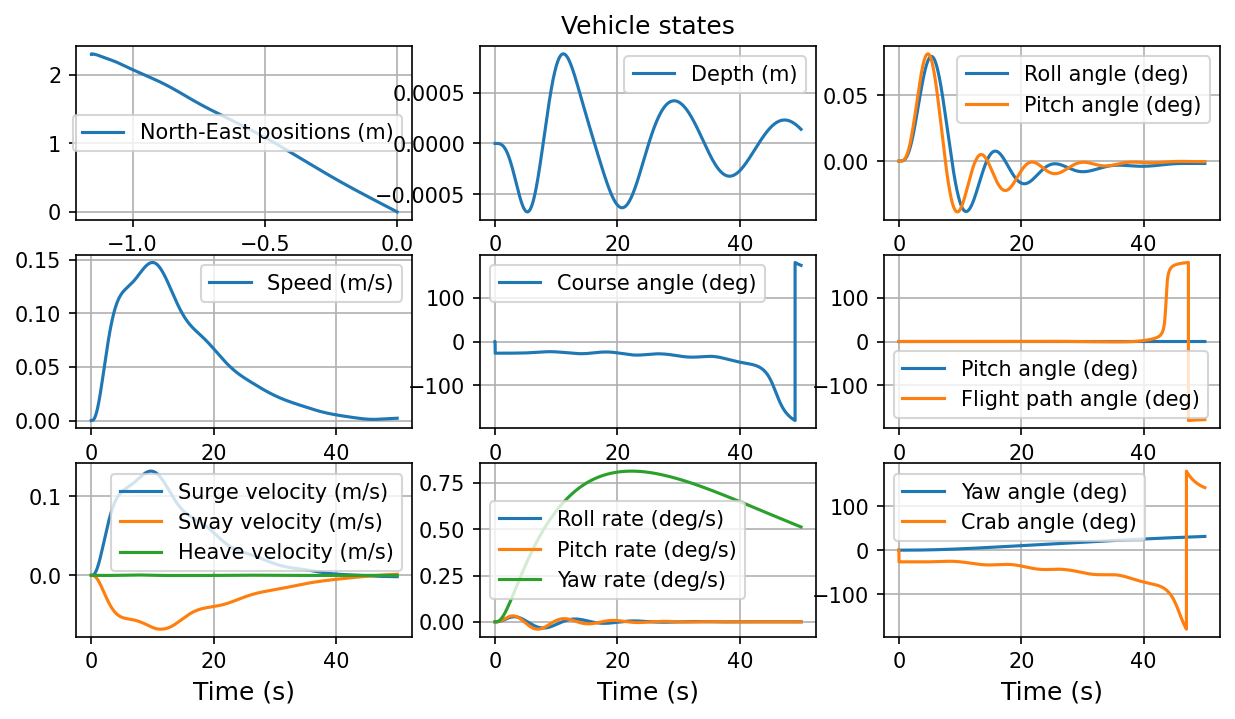

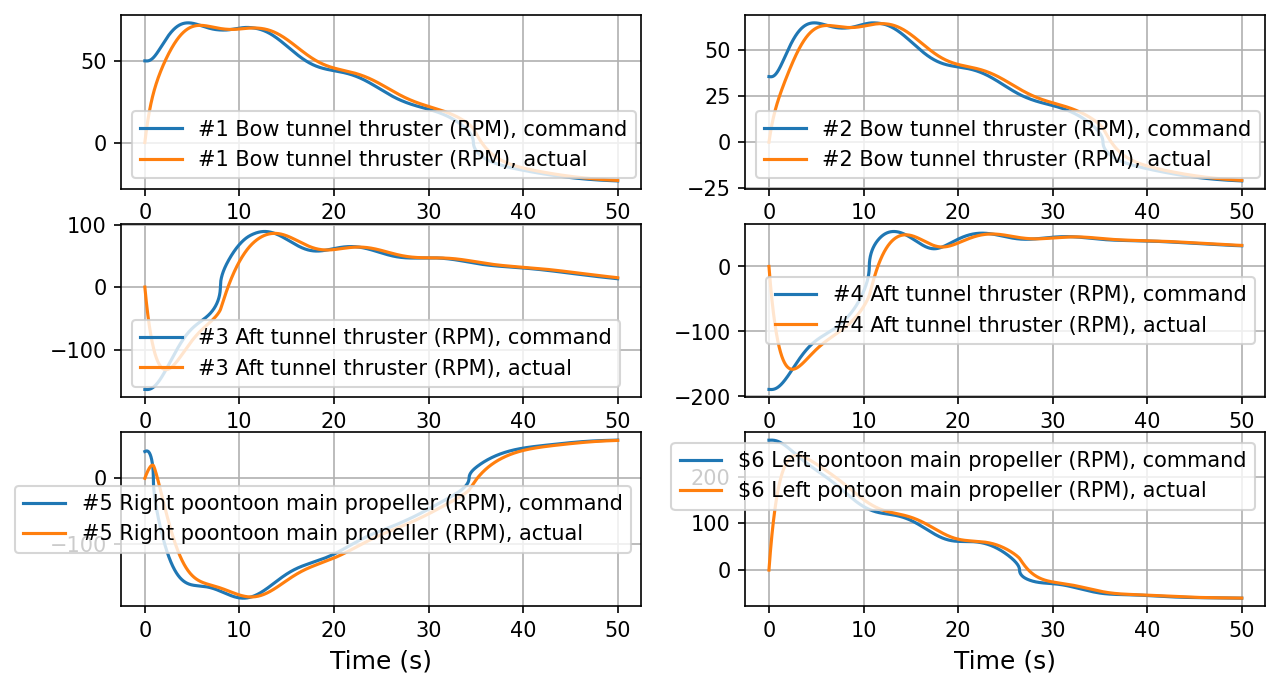

In [123]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [124]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

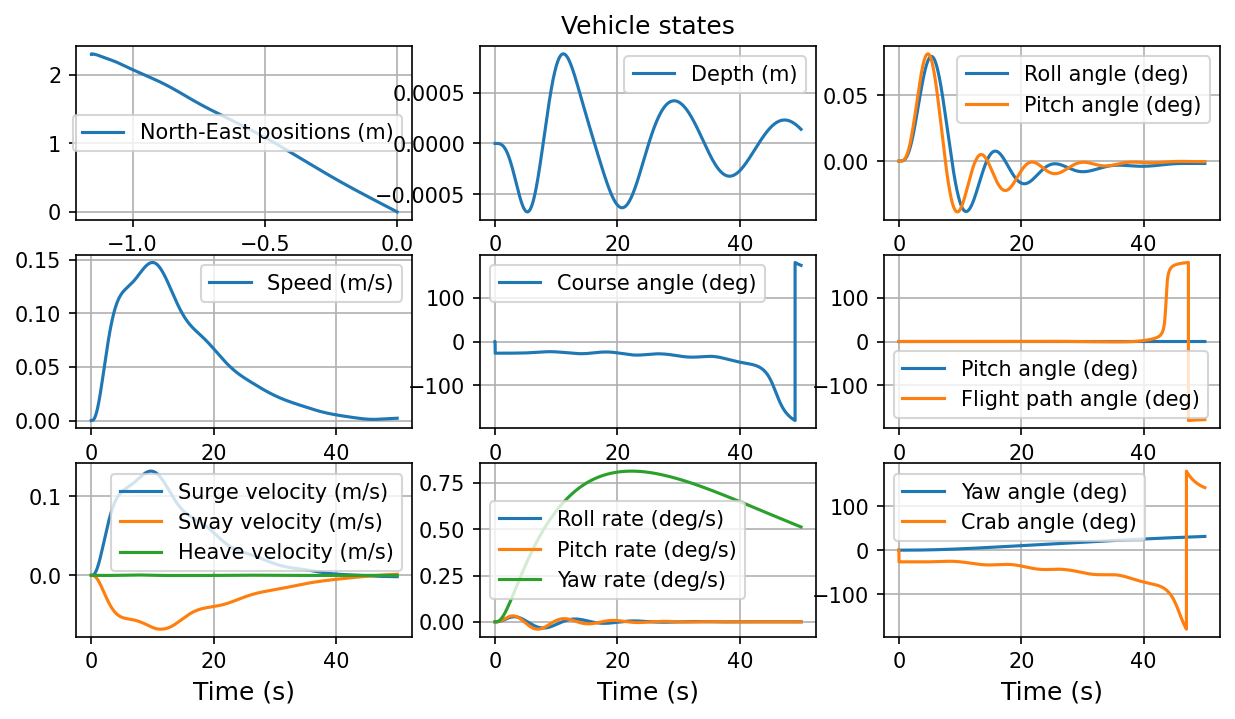

In [125]:
plotVehicleStates(simTime, simData, 3)

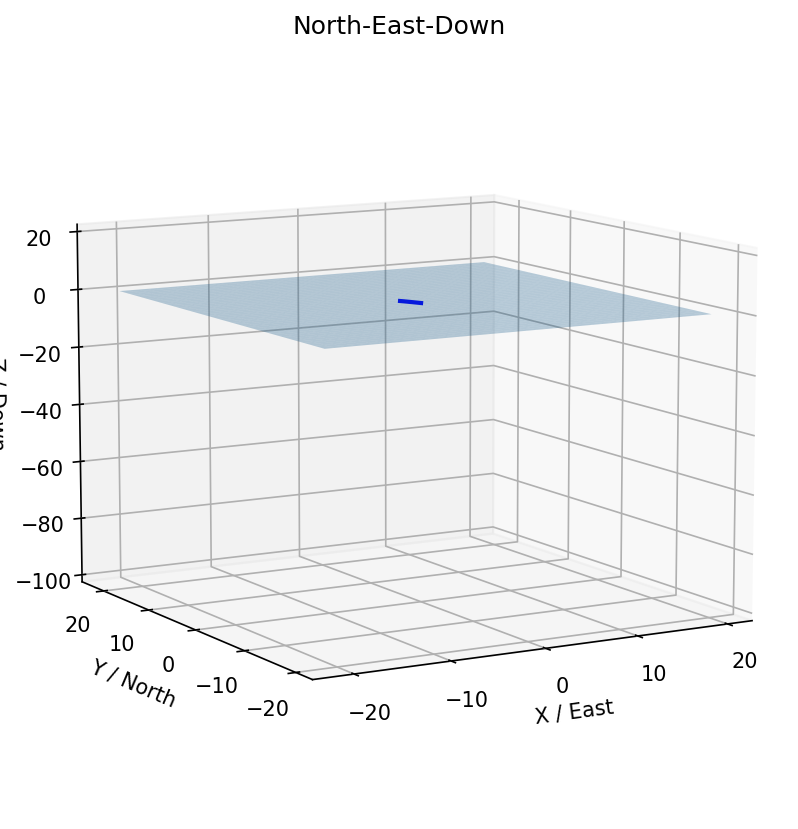

In [126]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [131]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [132]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(100)]
        self.wall_clock = datetime.now()

In [136]:
def grayscott1d(t, Q, coefs, T): 
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
   
    
    
#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]
    
    
#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])
  
    
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    
    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve - T.v_m[0]
    vessel_movement[1] = y_ve - T.v_m[1]
    vessel_movement[2] = z_ve - T.v_m[2]
    vessel_movement[3] = phi_ve - T.v_m[3]
    vessel_movement[4] = theta_ve - T.v_m[4]
    vessel_movement[5] = psi_v - T.v_m[5]    
    
    T.v_m[0] = x_ve
    T.v_m[1] = y_ve
    T.v_m[2] = z_ve
    T.v_m[3] = phi_ve
    T.v_m[4] = theta_ve
    T.v_m[5] = psi_v
    
    
#     else:
#         T.v_m[0] = 0.001
#         T.v_m[1] = 0
#         T.v_m[2] = 0
#         T.v_m[3] = 0
#         T.v_m[4] = 0
#         T.v_m[5] = 0
    
#     print(vessel_movement )
#     print(T.v_m,"l")
    
    
#     print(vessel_movement)
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     vessel_movement0=vessel_movement
#     print(fors.astype(np.float64))
    
    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()
#     print(fors)

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
    
    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
#     T.v_m=np.copy(vessel_movement)
  
    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [137]:
tspan = (0., 20)
T_ = MyTime()

In [138]:
coefs = [1, 1, 1, 1, 1, 1]

In [139]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,  
             tspan, 
             q0,
#             method='LSODA',
#              t_eval=[i*sampleTime/10 for i in range(int(tspan[-1]/(sampleTime/10)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.33856342627166447  Iteration wall clock time:  0:00:00.290030
Physical time:  1.0007249279966994  Iteration wall clock time:  0:13:58.920212
Physical time:  2.000623351745872  Iteration wall clock time:  1:29:14.022248
Physical time:  3.000056158227195  Iteration wall clock time:  2:34:34.818804
Physical time:  4.000032191755478  Iteration wall clock time:  1:31:14.133281
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_56565/1363789387.py", line 2, in <module>
    us=solve_ivp(grayscott1d,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/ivp.py", line 650, in solve_ivp
    message = solver.step()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py", line 197, in step
    success, message = self._step_impl()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py", line 144, in _step_impl
    y_new, f_new = rk_step(self.fun, t, y, self.f, h, self.A,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x17')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+17] ,'-')
plt.xlabel('t')
plt.ylabel('y17')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+17] ,'-')
plt.xlabel('t')
plt.ylabel('dy17')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+17] ,'-')
plt.xlabel('t')
plt.ylabel('z17')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()